# Forecasting PM2.5

## Part 1: Reframing the dataset

### Objective 

Once the data has been properly cleaned, a specific pollutant can be selected to forecast using a ML model. 

PM2.5 will be selected given that it's the pollutant with the most complete information and also it has great relevance as a main pollutant in Tlaquepaque.

Reframing the dataset involves reformating the information for supervised learning, i.e., a set of variables will be used as dependent variables (to give context) and they will each have an independent variable (result) assigned to them. For time series forecasting, it's important to also group these dependent and independent variables in windows of time. 

This allows the model to generalize the information of time (t-1) and use it to predict the results of time (t).

### Forecasting PM2.5

To forecast PM2.5, the features used will be:

_Exogenous variables (dependent variable):_

- Temperature (TMP)
- Relative Humidity (RH)
- Barometric Pressure (PBA)
- Wind Speed (WS)
- Wind Direction (WD)

_Pollutant (independent variable):_

- Fine Particulate Matter less than 2.5 micrometers (PM2.5)

This requires a multivariate model, which in this case will be LTSM.

In [ ]:
from math import sqrt

import numpy as np # Numerical operations
import pandas as pd # Dataset manipulation

import seaborn as sns # Graphs
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.preprocessing import MinMaxScaler # Scale data

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM # Model
from tensorflow.keras.layers import Dense, Dropout # Layer
from tensorflow.keras.optimizers import Adam # Optimizer function

from sklearn.metrics import mean_squared_error # Performance metrics
from sklearn.metrics import r2_score

import optuna # Hyperparameter optimization

import joblib # Save model

## Suppressing unnecessary warnings
import warnings
warnings.filterwarnings("ignore")

In [225]:
filename = "semadet-aire-final"
filepath = f"datasets/feature_eng/{filename}.csv"

# Read dataset
df = pd.read_csv(filepath, parse_dates=[0], index_col=0)

### Select pollutant to predict and exogenous variables

PM2.5 will be the forecasted pollutant using 5 features (__Temperature (TMP), Relative Humidity (RH), Barometric Pressure (PBA), Wind Speed (WS), Wind Direction (WD)__) to help give the model context about when certain readings occur. The information on these features need to be extracted from the rest of the dataset.

In [226]:
# Dependent variables
features = ["pm25", "tmp", "rh", "ws", "wd"]
n_features = len(features)

# Independent variable
pollutant = "pm25"
pollutant_idx = 0

In [227]:
# Create a dataframe with specified features
def select_df_features(df:pd.DataFrame, features:list)->pd.DataFrame:
    df_select = pd.DataFrame()
    for feature in features:
        df_select[feature] = df[feature]
    return df_select

In [228]:
# Create dataframe
df_select = select_df_features(df, features)

In [229]:
df.sort_index(ascending=False, inplace=True)

In [230]:
# Observe first three instances
df_select.head(3)

,pm25,tmp,rh,ws,wd
date,,,,,
2017-01-01,24.869231,19.475000,52.125000,2.516667,9.648721
2017-01-02,24.869231,19.358333,49.691667,1.291667,9.957045
2017-01-03,24.869231,19.970833,43.037500,1.062500,11.695896


### Normalize data

Once the data is separated, the data will be transformed to a common scale to improve the model's performance (scaling). 
Normalizing the data allows each feature to have values between a certain range, and depending on the activation functions the model uses, it could improve performance.

In this case, the data held for each feature will be scaled to have values between 0 and 1.

In [231]:
print(f"Dataframe shape: {df_select.values.shape}")

Dataframe shape: (1096, 5)


In [232]:
# Create a data scaler
data_scaler = MinMaxScaler(feature_range=(0,1))

# Scale the information in each column
data_norm = data_scaler.fit_transform(df_select.values)

In [233]:
# Observe the first 5 instances
data_norm[:5]

array([[0.22140047, 0.43233533, 0.54997636, 0.43192939, 0.02718241],
       [0.22140047, 0.42517661, 0.51689848, 0.21843369, 0.02805866],
       [0.22140047, 0.46275987, 0.42644408, 0.17849402, 0.03300044],
       [0.22140047, 0.50264415, 0.36096801, 0.20173165, 0.03609954],
       [0.22140047, 0.57934468, 0.26972064, 0.40723941, 0.04108343]])

### Timeseries to supervised learning

Supervised learning involves training and evaluating a model with information that is already has the correct result specified.

For the existing dataset, the dataset needs to be separated in instances of the five dependent features labeled with the correct result, which is the PM2.5 reading for a given day. This is already done.

Since this is also a time series forecasting problem, the data needs to be further split into windows of time. This means creating two overlapping groups of n and m instances, where:

- Group one has n past instances of the all variables to learn from
- Group two has m future instances of the desired variable to forecast (PM2.5)

These groups overlap because the first group has observations from [0,n],[1,n+1] and so on, the same happens for group 2.

This allows the model to learn how PM2.5 will change given certain circumstances, as well as use previously learned predictions to make new ones.


In [234]:
# Separate the data into two groups of windows of n instances 
def series_to_supervised(data:np.ndarray, column_names:list, 
                         n_dependent:int=1, n_pred:int=1, 
                         dropnan=True)->pd.DataFrame:
    
    # Obtain number of variables in data
    n_vars = 1 if type(data) is list else data.shape[1]
    
    # Create a dataframe of the data
    df = pd.DataFrame(data)
    
    # Save shifted columns and their names
    cols, names = list(), list()
    
    # Create the input sequence (t-n, ... t-1) number of past instances
    for i in range(n_dependent, 0, -1):
        # Shift all data in features i positions downwards
        cols.append(df.shift(i))
        
        # Save the name of the column and how many positions it was shifted
        names += [(f"{column_names[j]}(t-{i})") for j in range(n_vars)]
    
    # Forecast sequence (t, t+1, ... t+n) number of predictions
    for i in range(0, n_pred):
        # Shift all features i positions upwards
        cols.append(df.shift(-i))
        
        # Save the name of the colum  and the times it was shifted
        if i == 0:
            names += [(f"{column_names[j]}(t)") for j in range(n_vars)]
        else:
            names += [(f"{column_names[j]}(t+{i})") for j in range(n_vars)]
    
    # Join the resulting columns and give them column names
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    
    return agg

In [235]:
n_steps = 7
n_dependent = 23

In [236]:
# Obtained reframed dataset
data_reframed = series_to_supervised(data_norm, 
                                     features, 
                                     n_dependent=n_dependent, 
                                     n_pred=n_steps)

In [237]:
data_reframed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1067 entries, 23 to 1089
Columns: 150 entries, pm25(t-23) to wd(t+6)
dtypes: float64(150)
memory usage: 1.2 MB


Once the data has been reframed, only the feature that is to be forecasted should be kept (PM2.5) in the future timesteps groups (from time t forward). In other words, all features that aren't the independent one (pm25) will be dropped for time t onwards.

In [238]:
# Delete non independent variables from future timesteps

# Start index of future timesteps
start_pred = n_features * n_dependent

# End index of future timesteps
end_pred = start_pred + (n_features * n_steps)

columns_to_drop = [
    i for i in range(start_pred, end_pred) 
    if i % n_features != pollutant_idx
    ]

print("Columns to drop from time t onwards:")
print(columns_to_drop)

Columns to drop from time t onwards:
[116, 117, 118, 119, 121, 122, 123, 124, 126, 127, 128, 129, 131, 132, 133, 134, 136, 137, 138, 139, 141, 142, 143, 144, 146, 147, 148, 149]


In [239]:
# Drop columns we don't want to predict 
data_reframed.drop(data_reframed.columns[columns_to_drop], axis=1, inplace=True)

In [240]:
# See final reframed dataset
data_reframed.head(3)

,pm25(t-23),tmp(t-23),rh(t-23),ws(t-23),wd(t-23),pm25(t-22),tmp(t-22),rh(t-22),ws(t-22),wd(t-22),...,rh(t-1),ws(t-1),wd(t-1),pm25(t),pm25(t+1),pm25(t+2),pm25(t+3),pm25(t+4),pm25(t+5),pm25(t+6)
23,0.2214,0.432335,0.549976,0.431929,0.027182,0.2214,0.425177,0.516898,0.218434,0.028059,...,0.141997,0.358586,0.031285,0.2214,0.2214,0.2214,0.2214,0.2214,0.2214,0.2214
24,0.2214,0.425177,0.516898,0.218434,0.028059,0.2214,0.462760,0.426444,0.178494,0.033000,...,0.335083,0.441370,0.029722,0.2214,0.2214,0.2214,0.2214,0.2214,0.2214,0.2214
25,0.2214,0.462760,0.426444,0.178494,0.033000,0.2214,0.502644,0.360968,0.201732,0.036100,...,0.449440,0.391264,0.026718,0.2214,0.2214,0.2214,0.2214,0.2214,0.2214,0.2214


## Part 2: Divide dataset into training, validation and test sets

The machine learning model needs to be trained on different sets of the data so that it doesn't become used to only one kind of data. The dataset used has 3 years worth of information and will be divided in the following way:

- Training set: Year of 2023 and first nine months of 2020 (0.56%)
- Validation set: Last three months of 2020 (0.10%)
- Test set: Year of 2017

In [241]:
# Divide the dataset in train, validation and test set
def divide_series(df: pd.DataFrame, train:float=0.65, val:float=0.15):
    data_len = len(df)
    train_size = int(data_len * train)
    val_size = int(data_len * val)
    
    train_df = pd.DataFrame()
    val_df = pd.DataFrame()
    test_df = pd.DataFrame()
    
    for feature in df.columns:
        train_df[feature] = df[feature][:train_size]
        val_df[feature] = df[feature][train_size:train_size + val_size]
        test_df[feature] = df[feature][train_size + val_size:]
    

    return train_df, val_df, test_df

In [242]:
# Obtain 
train_df, val_df, test_df = divide_series(data_reframed, train=0.56, val=0.10)

/var/folders/b6/r8x8vgk95n1gjf60w26y4dr80000gn/T/ipykernel_888/1520083696.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[feature] = df[feature][:train_size]
/var/folders/b6/r8x8vgk95n1gjf60w26y4dr80000gn/T/ipykernel_888/1520083696.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  val_df[feature] = df[feature][train_size:train_size + val_size]
/var/folders/b6/r8x8vgk95n1gjf60w26y4dr80000gn/T/ipykernel_888/1520083696.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling

In [243]:
print(f"Train set len: {len(train_df)}")
print(f"Validation set len: {len(val_df)}")
print(f"Test set len: {len(test_df)}")

Train set len: 597
Validation set len: 106
Test set len: 364


In [244]:
train_df.head(3)

,pm25(t-23),tmp(t-23),rh(t-23),ws(t-23),wd(t-23),pm25(t-22),tmp(t-22),rh(t-22),ws(t-22),wd(t-22),...,rh(t-1),ws(t-1),wd(t-1),pm25(t),pm25(t+1),pm25(t+2),pm25(t+3),pm25(t+4),pm25(t+5),pm25(t+6)
23,0.2214,0.432335,0.549976,0.431929,0.027182,0.2214,0.425177,0.516898,0.218434,0.028059,...,0.141997,0.358586,0.031285,0.2214,0.2214,0.2214,0.2214,0.2214,0.2214,0.2214
24,0.2214,0.425177,0.516898,0.218434,0.028059,0.2214,0.462760,0.426444,0.178494,0.033000,...,0.335083,0.441370,0.029722,0.2214,0.2214,0.2214,0.2214,0.2214,0.2214,0.2214
25,0.2214,0.462760,0.426444,0.178494,0.033000,0.2214,0.502644,0.360968,0.201732,0.036100,...,0.449440,0.391264,0.026718,0.2214,0.2214,0.2214,0.2214,0.2214,0.2214,0.2214


### Split the data into X and y sets

Once the data has been separated into these sets, they need to be further separated into X and y sets, which only means separating the dependent variables (not PM2.5) from the independent variables (PM2.5). Or in the time series case, windows of past n observations from m future observations.

In [245]:
# Obtain the values for each set of data
train_values = train_df.values
val_values = val_df.values
test_values = test_df.values

In [246]:
# Create the X set by using all columns except last for all instances
# Create y set by only using the last column for all instances

train_X, train_y = train_values[:,:-n_steps], train_values[:,-n_steps:]
val_X, val_y = val_values[:,:-n_steps], val_values[:,-n_steps:]
test_X, test_y = test_values[:,:-n_steps], test_values[:,-n_steps:]

In [247]:
print(f"Shape of train X: {train_X.shape}")
print(f"Shape of train y: {train_y.shape}")
print(f"Shape of test X: {test_X.shape}")
print(f"Shape of test y: {test_y.shape}")

Shape of train X: (597, 115)
Shape of train y: (597, 7)
Shape of test X: (364, 115)
Shape of test y: (364, 7)


### Reshape data for model

The majority of M.L. models requiere the X set to be reshaped in the following format [n_instances, n_timesteps, n_features]

In [249]:
# Reshape each set
train_X = train_X.reshape(train_X.shape[0], n_dependent, n_features)
val_X = val_X.reshape(val_X.shape[0], n_dependent, n_features)
test_X = test_X.reshape(test_X.shape[0], n_dependent, n_features)

In [265]:
# Shape after reshaping
print(f"Shape of train X for model: {train_X.shape}")
print(f"Shape of train y for model: {train_y.shape}")
print(f"Shape of test X for model: {test_X.shape}")
print(f"Shape of test y for model: {test_y.shape}")

Shape of train X for model: (597, 23, 5)
Shape of train y for model: (597, 7)
Shape of test X for model: (364, 23, 5)
Shape of test y for model: (364, 7)


## Part 3: Define and fit the model 

Once the data has been properly separated, the model can be created. Choosing a model that adapts to the data is an important step that often requieres various trials and some research. After reviewing many papers about similar tasks related to pollutant forecasting and air quality predictors, the Multiple Layer Perceptron and Long Short Term Memory Models seemed to yield the better performance for this particular type of task.

### Searching for optimal hyperparameters

Optuna is a hyperparameter tuning framework that allows the user to select various hyperparameter options for a model and evaluates the performance of each during a set amount of trials.

#### Choosing hyperparameters

During my research and different trials, I found that for this specific problem, the following hyperparameters were viable options:

- Number of hidden layers
    - Value: 1,2,3
    - Opinion: I found that more layers can often be a disadvantage that can lead to poor learning, one is often best.

- Learning rate:
    - Value: 0.001, 0.1
    - Opinion: A learning rate that is too high can cause information loss

- Epochs:
    - Value: 50, 100
    - Opinion: Too many epochs can cause the network to overcorrect the error when propagating 

- Nodes per layer:
    - Value: 5, 50, 12, 8
    - Opinion: Less nodes is often better

- Batch size:
    - Value: 10, 32, 72
    - A smaller batch size can prevent overfitting, but some methodologies state that it's better to "increase the batch size instead of dropping the learning rate"

- Activation Function:
    - Values: ReLu

- Optimizer:
    Value: Adam

In [285]:
class MLPOptimizer:
  """
  Class for hyperparameter optimizing for PM2.5 Forecaster.
  """
  def __init__(self, input_dim:int, n_trials:int):
    self.input_dim = input_dim
    self.n_trials = n_trials
    self.study = None
    self.X_train = None
    self.y_train = None
    self.X_val = None
    self.y_val = None

  def create_model(self, trial):
    model = Sequential()

    # Hyperparameter selection
    neurons = trial.suggest_categorical("neurons", [10, 50, 100])
    # neurons_2 = trial.suggest_categorical("neurons_2", [10, 50, 100])
    # dropout_rate = trial.suggest_categorical("dropout", [0.0, 0.1, 0.2])
    
    model.add(LSTM(neurons, 
               input_shape=(self.X_train.shape[1], self.X_train.shape[2]),
               activation="relu"
               ))
    
    # model.add(Dropout(dropout_rate))
    
    # model.add(LSTM(neurons_2, activation="relu"))

    # Output layer
    model.add(Dense(7))

    # Compile model
    learning_rate = 0.001
    model.compile(optimizer=Adam(learning_rate), loss="mse")

    return model

  def objective(self, trial):
    model = self.create_model(trial)
    epochs = trial.suggest_categorical("epochs", [200, 100, 50, 30])
    batch_size = trial.suggest_categorical("batch_size", [32, 10, 72, 100])

    # Train the model
    model.fit(
        self.X_train,
        self.y_train,
        epochs=epochs,
        validation_data=(self.X_val, self.y_val),
        verbose=0,
        batch_size=batch_size,
        )

    # Evaluate on validation data
    loss = model.evaluate(self.X_val, self.y_val, verbose=0)

    return loss

  def optimize(self, X_train:np.array, y_train:np.array, X_val, y_val:np.array):
    self.X_train = X_train
    self.y_train = y_train
    self.X_val = X_val
    self.y_val = y_val

    self.study = optuna.create_study(direction="minimize")
    self.study.optimize(self.objective, n_trials = self.n_trials)

    print("Best hyperparameters:", self.study.best_params)
    return self.study

In [287]:
mlp_optimizer = MLPOptimizer(n_steps, n_trials=200)
study = mlp_optimizer.optimize(train_X, train_y, val_X, val_y)

[I 2025-05-01 17:51:46,313] A new study created in memory with name: no-name-ff631fad-0dba-49b9-a37d-773201d16019
[I 2025-05-01 17:51:58,166] Trial 0 finished with value: 0.011520923115313053 and parameters: {'neurons': 10, 'epochs': 100, 'batch_size': 10}. Best is trial 0 with value: 0.011520923115313053.
[I 2025-05-01 17:52:05,535] Trial 1 finished with value: 0.012899533845484257 and parameters: {'neurons': 50, 'epochs': 50, 'batch_size': 10}. Best is trial 0 with value: 0.011520923115313053.
[I 2025-05-01 17:52:09,507] Trial 2 finished with value: 0.010765651240944862 and parameters: {'neurons': 100, 'epochs': 50, 'batch_size': 100}. Best is trial 2 with value: 0.010765651240944862.
[I 2025-05-01 17:52:17,237] Trial 3 finished with value: 0.008834067732095718 and parameters: {'neurons': 10, 'epochs': 200, 'batch_size': 100}. Best is trial 3 with value: 0.008834067732095718.
[I 2025-05-01 17:52:26,062] Trial 4 finished with value: 0.013782172463834286 and parameters: {'neurons': 100

Best hyperparameters: {'neurons': 10, 'epochs': 200, 'batch_size': 72}


### Create model

The first layer in the network must define the number of inputs to expect. Input must be three-dimensional, comprised of samples, timesteps, and features.

In [1]:
# design network
model = Sequential()

model.add(LSTM(8, 
               input_shape=(train_X.shape[1], train_X.shape[2]),
               activation="relu"))

# Output layer
model.add(Dense(7))

model.compile(loss='mse', optimizer=Adam(0.001))

# fit network
history = model.fit(
    train_X, 
    train_y, 
    epochs=100, 
    batch_size=10, 
    validation_data=(val_X, val_y),
    verbose=1, 
    shuffle=False,
    )

NameError: name 'Sequential' is not defined

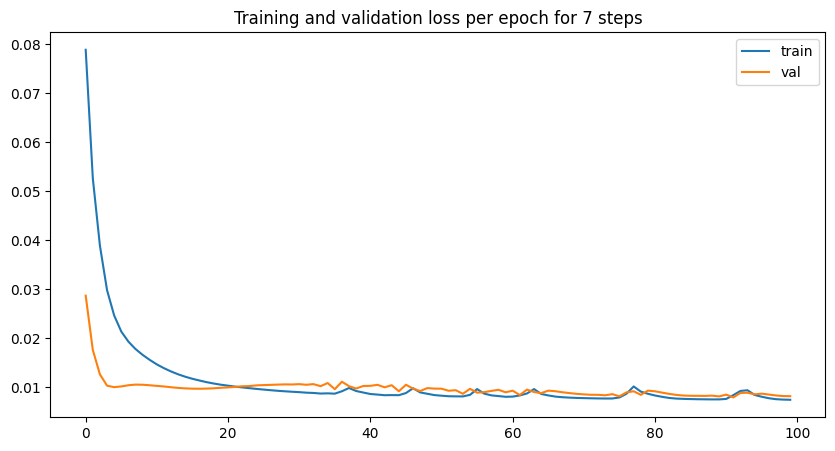

In [ ]:
# plot history
plt.figure(figsize=(10, 5))
plt.title(f"Training and validation loss per epoch for {n_steps} steps")
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
# plt.savefig(f"graphs/ltsm/{n_steps}_steps_training_val_loss.png")
plt.show()

### Predict values and evaluate performance

In [ ]:
# make a prediction
yhat = model.predict(test_X)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [ ]:
print(f"Model y prediction shape: {yhat.shape}")

Model y prediction shape: (364, 7)


Once the pollutant values have been predicted, the scaling needs to be inverted to see what values have been predicted. In order to do this, the scaler needs to recieve an array of the same shape as the original dataframe. A dummy array can be created with zeroes placed in all the columns that aren't the independent variable to give as parameter to the `inverse_transform` function.

In [ ]:
# Inverse scaling for predicted y values
n_samples = test_y.shape[0]

# Placeholder for full features needed by scaler
dummy = np.zeros((n_samples * n_steps, n_features))

# Flatten yhat to 1D, and place it into dummy
dummy[:, pollutant_idx] = yhat.reshape(-1)

# Inverse transform
inv_yhat = data_scaler.inverse_transform(dummy)

# Extract only the pollutant (independent variable) from the result
inv_yhat = inv_yhat[:, pollutant_idx].reshape(test_y.shape)

In [ ]:
# Inverse scaling for actual y values 
dummy_actual = np.zeros((n_samples * n_steps, n_features))
dummy_actual[:, pollutant_idx] = test_y.reshape(-1)

inv_y = data_scaler.inverse_transform(dummy_actual)
inv_y = inv_y[:, pollutant_idx].reshape(test_y.shape)

In [ ]:
for i in range(n_steps):
    step_rmse = np.sqrt(mean_squared_error(inv_y[:, i], inv_yhat[:, i]))
    print(f"Step t+{i+1} RMSE: {step_rmse:.3f}")

Step t+1 RMSE: 13.666
Step t+2 RMSE: 22.521
Step t+3 RMSE: 20.017
Step t+4 RMSE: 19.570
Step t+5 RMSE: 22.695
Step t+6 RMSE: 22.488
Step t+7 RMSE: 19.809


In [ ]:
for i in range(len(inv_y)):
    print(f"Instance {i+1}")
    for j in range(n_steps):
        print(f"  t+{j+1} Actual: {inv_y[i,j]:.3f}  Predict: {inv_yhat[i,j]:.3f}")

Instance 1
  t+1 Actual: 33.545  Predict: 35.462
  t+2 Actual: 33.545  Predict: 44.463
  t+3 Actual: 33.545  Predict: 38.339
  t+4 Actual: 33.545  Predict: 37.938
  t+5 Actual: 33.545  Predict: 38.873
  t+6 Actual: 18.194  Predict: 36.050
  t+7 Actual: 18.194  Predict: 42.242
Instance 2
  t+1 Actual: 33.545  Predict: 35.865
  t+2 Actual: 33.545  Predict: 45.324
  t+3 Actual: 33.545  Predict: 39.748
  t+4 Actual: 33.545  Predict: 38.659
  t+5 Actual: 18.194  Predict: 39.799
  t+6 Actual: 18.194  Predict: 37.028
  t+7 Actual: 24.248  Predict: 43.412
Instance 3
  t+1 Actual: 33.545  Predict: 36.507
  t+2 Actual: 33.545  Predict: 46.189
  t+3 Actual: 33.545  Predict: 41.282
  t+4 Actual: 18.194  Predict: 39.661
  t+5 Actual: 18.194  Predict: 40.980
  t+6 Actual: 24.248  Predict: 38.328
  t+7 Actual: 42.726  Predict: 44.614
Instance 4
  t+1 Actual: 33.545  Predict: 37.807
  t+2 Actual: 33.545  Predict: 48.092
  t+3 Actual: 18.194  Predict: 42.873
  t+4 Actual: 18.194  Predict: 41.478
  t+5 

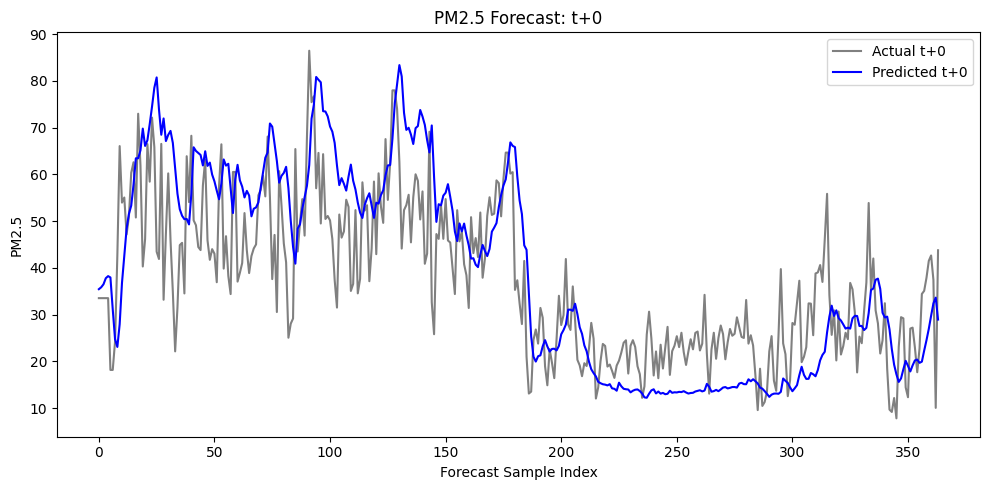

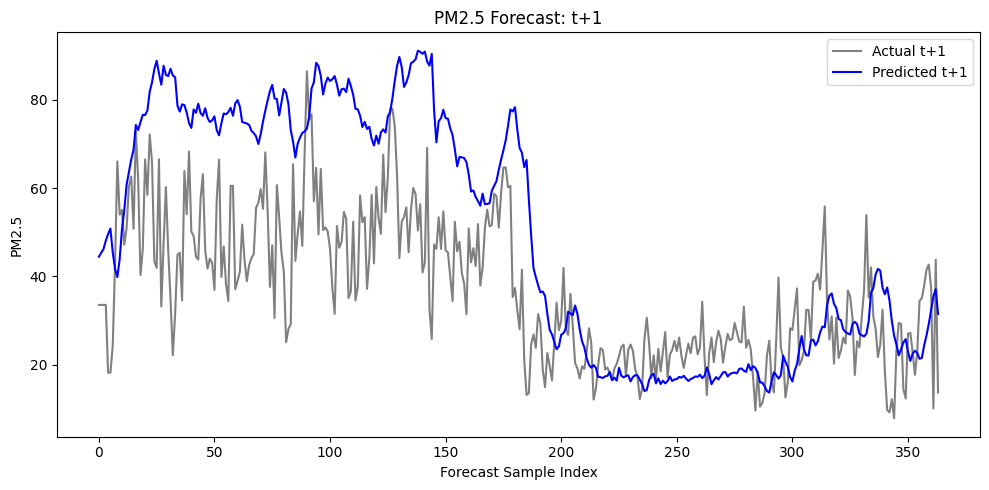

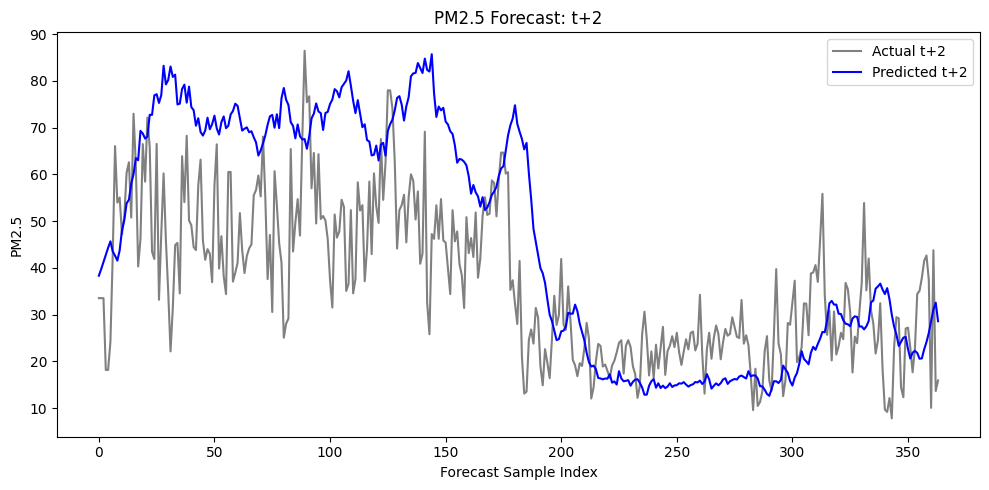

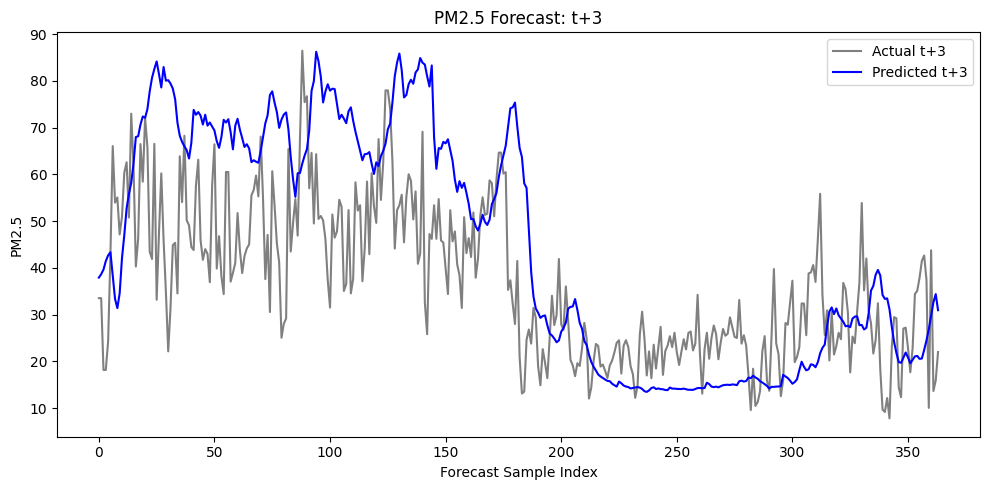

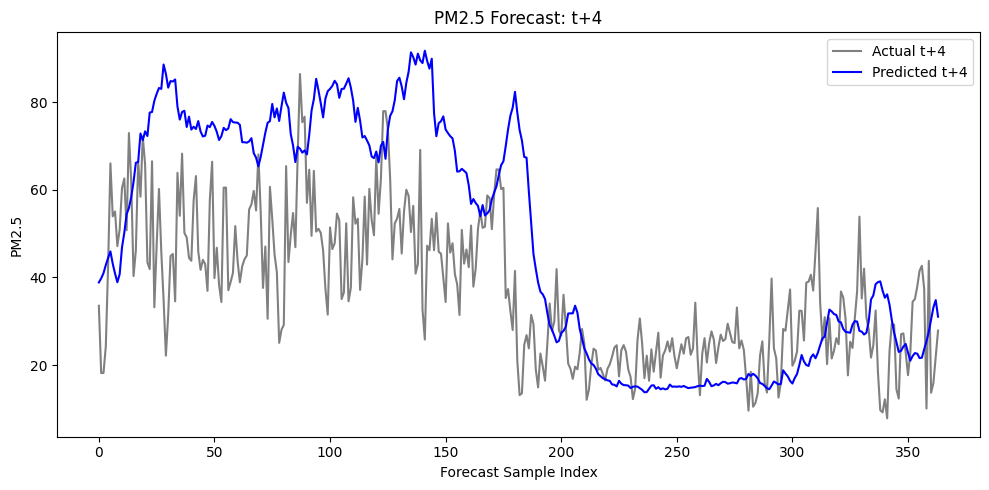

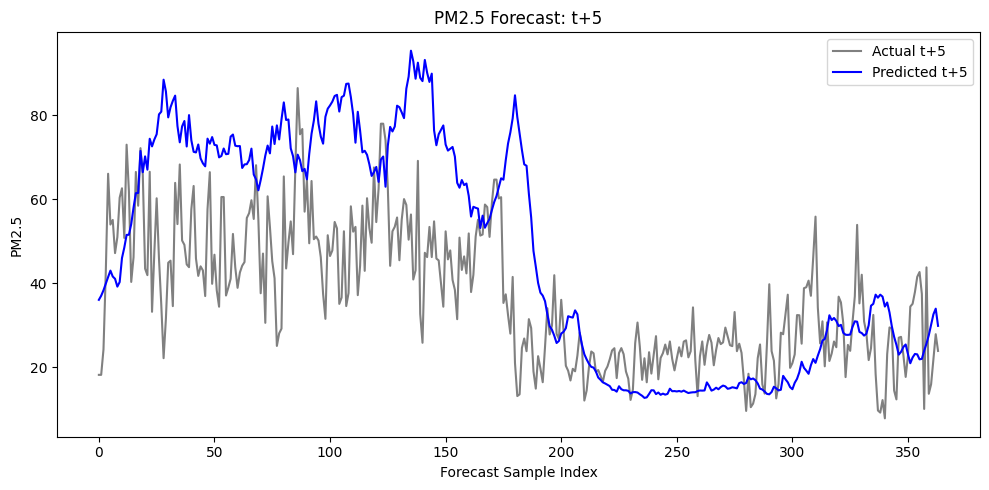

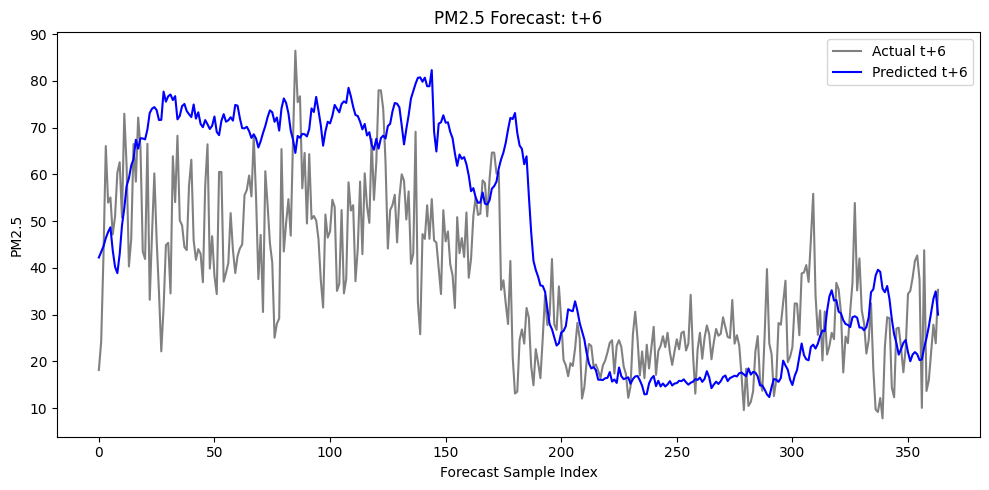

In [ ]:
actual_color = 'gray'    # pastel red
predicted_color = 'blue' # pastel blue

for step in range(n_steps):
    plt.figure(figsize=(10,5))
    
    plt.plot(np.arange(len(inv_yhat[:, step])), inv_y[:, step], 
             linestyle='-', color=actual_color, label=f'Actual t+{step}')
    
    plt.plot(np.arange(len(inv_yhat[:, step])), inv_yhat[:, step], 
             linestyle='-', color=predicted_color, label=f'Predicted t+{step}')
    
    plt.title(f'PM2.5 Forecast: t+{step}')
    plt.xlabel('Forecast Sample Index')
    plt.ylabel('PM2.5')
    plt.legend()
    plt.tight_layout()
    
    # plt.savefig(f"graphs/ltsm/t_plus_{step+1}_pred.png")
    plt.show()

## Save the model

Once the model has reached an acceptable performance, it can be saved to a file in order to be used in the future.

In [ ]:
# Save the model as a pickle in a file 
# joblib.dump(model, f'ltsm_{n_steps}_step.pkl') 

In [ ]:
# Load the model from the file 
# knn_from_joblib = joblib.load('ltsm.pkl') 
  
# Use the loaded model to make predictions 
# knn_from_joblib.predict(test_X) 